Author: Lucas Camponogara Viera.

# About TensorFlow

TensorFlow is a library used for tensor (multidimensional array) manipulations and automatic differentiation, i.e., for optimizing parameters through techniques such as gradient descent. Similar to NumPy and CuPy, Tensorflow can be used for linear algebra operations such as inner product (dot product), outer product, matrix-vector, and matrix-matrix multiplications, to name a few.

- Tensorflow (and also NumPy and Pytorch) offers the `tf.einsum` implementation of Einstein summation convention to facilitate linear algebra operations.

- In deep learning, Tensorflow is used for the backend of neural networks that are implemented using Keras (a high-level neural network API).

- When preparing a dataset for deep learning, is a best practice to use TF tensors rather than NumPy arrays for seamless integration.

# Rule-of-thumbs

1. `Ockham's razor:` when there are two competing theories that make exactly the same predictions, the simpler one is better. In model complexity, the more complex the model, the more prone the model is to overfitting as the size of the dataset decreases. Therefore, one should always start with a baseline model.
2. `Learning principle:` random features (noise) cannot be learned. In a data-driven approach, the dataset must share a pattern of meaningful representation.
3. `Hold-out set:` it is a good practice to split the dataset into training, test, and validation.
4. `Dataset size:` the larger the dataset, the higher the generalization of the model to unseen data.
5. `Samples per parameter in Neural Networks:` ideally, there should be 10x the number of samples (feature-label pairs) than parameters (weights) in a neural network, i.e, ten examples per weight.
6. `Network depth:` the deeper the network (number of layers), the more information is extracted (learned).
7. `Bias-variance trade-off:` while under-parametrization can cause bias (underfitting), over-parametrization can cause variance (overfitting). In mainstream machine learning, one tries to find a balance.
8. `Double descent:` over-parametrization beyond certain interpolation threshold can lead to model generalization (good test performance). Moreover, as the size of the parameter vector to be optimized increases (as large as one million), the local minima get closer to the global minimum.
9. `Batch size:` a larger batch size (increase memory resource) leads to a speed up in training and to a lower asymptotic test accuracy (classification), and hence a lower generalization to unseen data.
10. `Learning rate:` a higher learning rate can speed-up training, however, too large a learning rate can make the loss function value to jiggle around the loss landscape and to never converge.

# Dependencies

In [4]:
# Dataset
import random
import numpy as np
#from sklearn.datasets import load_iris

# Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Input

# Plotting
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.14.0'

In [6]:
import sys
sys.version

'3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]'

# Dummy dataset

In [7]:
# Fake MNIST dataset
num_classes = 10
num_samples = 100
height = 28
width = height
num_channels = 1 # Grayscale.
train_shape = (num_samples, height, width, num_channels)
label_shape = (num_samples, num_classes)

# Normal data
mean = 0
stddev = 1

# NumPy:
#dummy_x = np.random.normal(mean, stddev, size=train_shape)

# TensorFlow:
dummy_x = tf.random.normal(shape=train_shape, mean=mean, stddev=stddev)

# Labels:
dummy_y = tf.random.normal(shape=label_shape, mean=mean, stddev=stddev)

#print(dummy_x.mean(), dummy_x.std()) # For NumPy only.
dummy_x.shape, dummy_y.shape

(TensorShape([100, 28, 28, 1]), TensorShape([100, 10]))

In [8]:
# Hold-out set

x_train = dummy_x[:50] # First 50.
y_train = dummy_y[:50]
x_val = dummy_x[50:] # Remaining ones.
y_val = dummy_y[50:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(TensorShape([50, 28, 28, 1]),
 TensorShape([50, 10]),
 TensorShape([50, 28, 28, 1]),
 TensorShape([50, 10]))

# Sequential API

In [9]:
'''
Conv2D -> BatchNormalization -> Activation -> MaxPooling2D
Note: It is not recommended to use Dropout and BatchNormalization at the same time.
'''

# Define the model
model = Sequential()

# Define the input shape:
input_shape, num_classes = (28, 28, 1), 10
#input_shape, num_classes = (4,), 3

# Supposing the input is a vector instead of a 3D tensor, one needs to reshape it before using a Conv2D layer:
#model.add(Reshape((2, 2, 1), input_shape=input_shape))

# Conv Layer:
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape)) 

# Normalization:
model.add(BatchNormalization()) 

# Activation (non-trainable):
model.add(Activation('relu')) 

# Pooling Layer to halve the feature map size (non-trainable):
model.add(MaxPooling2D((2, 2))) 

# Conv Layer:
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 

# Flattening, i.e., converting to a vector (non-trainable):
model.add(Flatten()) 

# Dropout (non-trainable). 
#model.add(Dropout(0.2)) 

# Dense (fully-connected) Layer:
model.add(Dense(50, activation='relu')) # Out Shape = (batch_size, 50)

# Output Layer uses 10 neurons (10 classes) with softmax activation function for multiclass classification:
model.add(Dense(num_classes, activation='softmax')) # Out Shape = (batch_size, num_classes)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 12544)             0

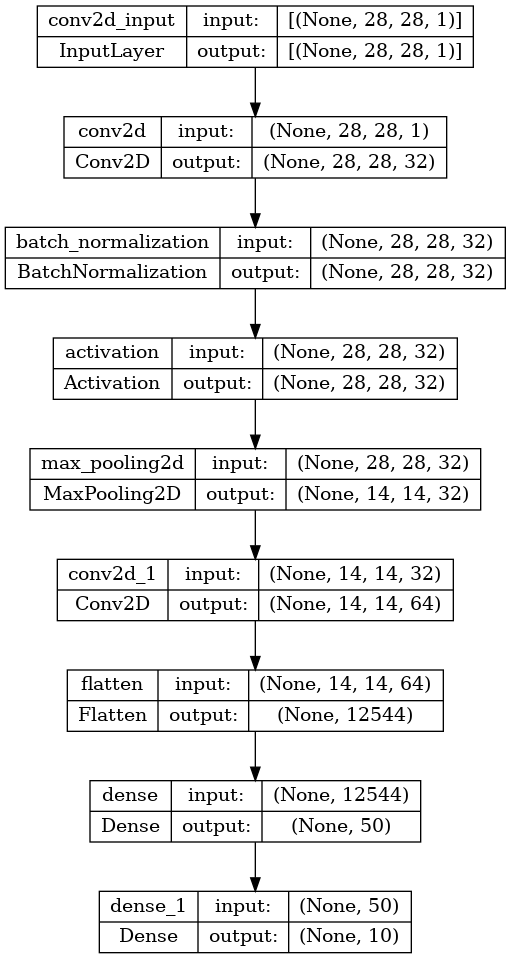

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Functional API

In [11]:
'''
Conv2D -> BatchNormalization -> Activation -> MaxPooling2D
Note: It is not recommended to use Dropout and BatchNormalization at the same time.
'''

# Define the input shape:
input_shape, num_classes = (28, 28, 1), 10
#input_shape, num_classes = (4,), 3

# Input Layer:
input_layer = Input(shape=input_shape)

# Reshape the input
#input_layer = Reshape((2, 2, 1))(input_layer)

# Conv Layer:
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1))(input_layer)
assert x.shape == (None, 28, 28, 32), 'Assertion Error, wrong shape!'
#assert x.shape == (None, 2, 2, 32), 'Assertion Error, wrong shape!'

# Normalization:
x = BatchNormalization()(x)

# Activation (non-trainable):
x = Activation('relu')(x)

# Pooling Layer to halve the feature map size (non-trainable):
x = MaxPooling2D((2, 2))(x)

# Conv Layer:
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Flattening, i.e., converting to a vector (non-trainable):
x = Flatten()(x)

# Dropout (non-trainable). 
#x = Dropout(0.2)(x)

# Dense (fully-connected) Layer:
x = Dense(50, activation='relu')(x)
#x = Dense(50)(x)
#x = Activation('relu')(x)

# Output Layer uses 10 neurons (10 classes) with softmax activation function for multiclass classification:
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496 

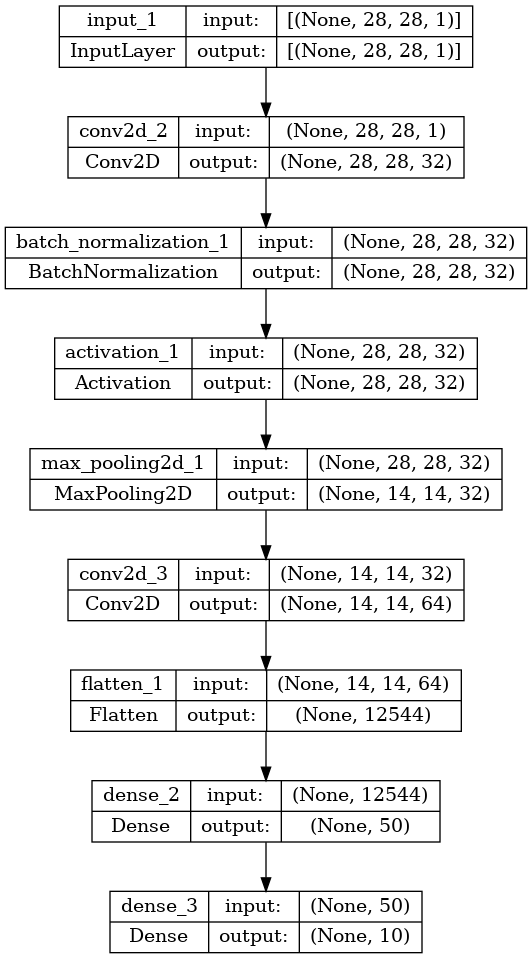

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

# OOP

In [16]:
class NeuralNetwork(Model):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', strides=(1, 1))
        self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.batch_norm = BatchNormalization()
        self.activation = Activation('relu')
        self.max_pooling = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(50, activation='relu')
        self.output_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.max_pooling(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

In [17]:
model = NeuralNetwork(num_classes=10)
sample_input = tf.ones((10, 28, 28, 1))  # Create a sample input with desired shape.
model(sample_input)  # Pass the sample input through the model to build it.
print(model.summary())

Model: "neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  320       
                                                                 
 conv2d_7 (Conv2D)           multiple                  18496     
                                                                 
 batch_normalization_3 (Bat  multiple                  128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         multiple             

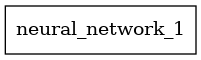

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train

Dummy dataset.

In [19]:
# Hyperparameters
learning_rate = 1e-4
momentum = 0.9
epochs = 5
batch_size = 1

# Model
model = NeuralNetwork(num_classes=10)

# Loss
loss = 'categorical_crossentropy'
metrics = 'accuracy'

# Optimizers
optimizer1 = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True, name='SGD')
optimizer2 = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
optimizer3 = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1 = 0.9, beta_2 = 0.999)

In [20]:
# Compile
model.compile(loss=loss, optimizer=optimizer1, metrics=[metrics])

# Train the model
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/5
50/50 [==============================] - 1s 11ms/step - loss: 1.9650 - accuracy: 0.1000 - val_loss: 0.7121 - val_accuracy: 0.0600
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: -1.9823 - accuracy: 0.1400 - val_loss: 1.4754 - val_accuracy: 0.1400
Epoch 3/5
50/50 [==============================] - 0s 7ms/step - loss: 11.6709 - accuracy: 0.1600 - val_loss: 63.3521 - val_accuracy: 0.1400
Epoch 4/5
50/50 [==============================] - 0s 7ms/step - loss: 144.6266 - accuracy: 0.0800 - val_loss: 0.7841 - val_accuracy: 0.1000
Epoch 5/5
50/50 [==============================] - 0s 7ms/step - loss: -7.9318 - accuracy: 0.1200 - val_loss: 1.8648 - val_accuracy: 0.0600


# Example: MNIST

## Data Preprocessing

In [21]:
# Loading dataset:
(X, Y), (x_test, y_test) = keras.datasets.mnist.load_data()

X.shape, Y.shape, x_test.shape, y_test.shape, type(X)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), numpy.ndarray)

In [22]:
# Shuffling indices:

random.seed(1)
size = len(X)
indices = random.sample(range(size), size)

# Splitting dataset into training and validation:

x_train = X[indices[:50000]]
y_train = Y[indices[:50000]]
x_val = X[indices[50000:]]
y_val = Y[indices[50000:]]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

# Scaling dataset to the range [0, 1]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_val = x_val.astype("float32") / 255

x_train.max(), x_val.max(), x_test.max(), 

(50000, 28, 28)
(50000,)
(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


(1.0, 1.0, 1.0)

In [23]:
def one_hot_encode(target: np.ndarray) -> np.ndarray:
    '''
    Perform one-hot encoding of labels.
    
    Args:
      - target (numpy.ndarray): the array of labels. 
    
    Returns:
      - outputs (numpy.ndarray): the array of labels in one-hot encoding format.
    
    Example:
    >>> one_hot(np.array([0,1,3]))
    array([[1., 0., 0., 0.],
           [0., 1., 0., 0.],
           [0., 0., 0., 1.]])
    '''
    no_classes = np.max(target)+1 # Total number of classes.
    new = np.zeros((target.shape[0], no_classes)) 
    for i, x in enumerate(target): 
        new[i,x] = 1 
    return new

''' 
# Alternative:

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
'''

y_train, y_test, y_val = one_hot_encode(y_train), one_hot_encode(y_test), one_hot_encode(y_val)

In [25]:
# Converting dataset to TF tensors:

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

# Reshaping features to (size, 28, 28, 1):

x_train = tf.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_val = tf.reshape(x_val, (x_val.shape[0], 28, 28, 1))
x_test = tf.reshape(x_test, (x_test.shape[0], 28, 28, 1))

In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

print(type(y_test))

(50000, 28, 28, 1)
(50000, 10)
(10000, 28, 28, 1)
(10000, 10)
(10000, 28, 28, 1)
(10000, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Training

In [169]:
# Compile
model.compile(loss=loss, optimizer=optimizer1, metrics=[metrics])

# Train the model
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size=batch_size, epochs=50)

Epoch 1/50
50000/50000 [==============================] - 237s 5ms/step - loss: 0.2927 - accuracy: 0.9099 - val_loss: 0.1301 - val_accuracy: 0.9611
Epoch 2/50
50000/50000 [==============================] - 232s 5ms/step - loss: 0.0806 - accuracy: 0.9754 - val_loss: 0.1011 - val_accuracy: 0.9698
Epoch 3/50
50000/50000 [==============================] - 233s 5ms/step - loss: 0.0553 - accuracy: 0.9830 - val_loss: 0.1279 - val_accuracy: 0.9611
Epoch 4/50
50000/50000 [==============================] - 233s 5ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0.0754 - val_accuracy: 0.9779
Epoch 5/50
50000/50000 [==============================] - 233s 5ms/step - loss: 0.0372 - accuracy: 0.9882 - val_loss: 0.0663 - val_accuracy: 0.9817
Epoch 6/50
50000/50000 [==============================] - 234s 5ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.1138 - val_accuracy: 0.9642
Epoch 7/50
50000/50000 [==============================] - 234s 5ms/step - loss: 0.0258 - accuracy: 0.9919 - val_

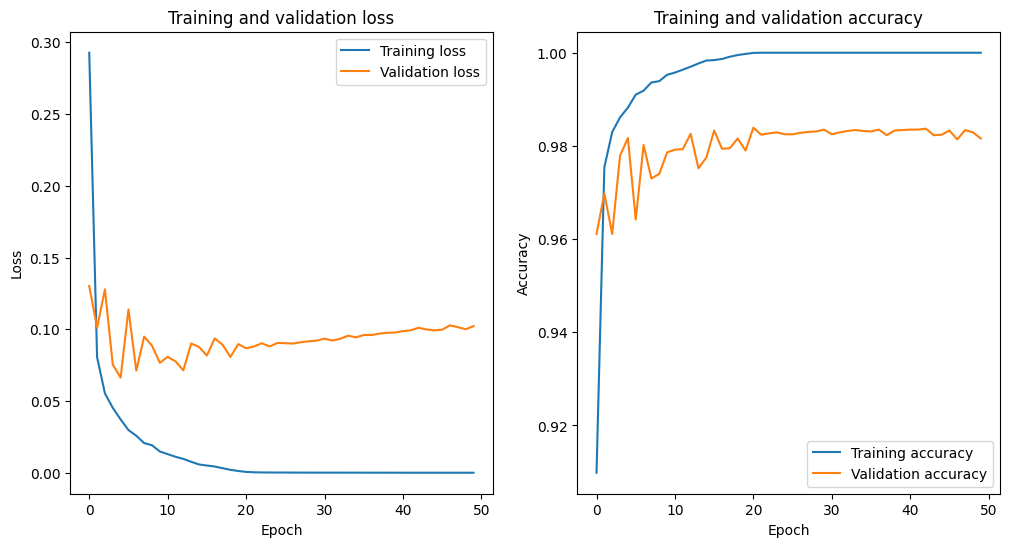

In [170]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation loss
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()
    
plot_history(history)

## Predictions

In [293]:
def get_label(label_array):
    return np.argmax(label_array) # np.argmax returns the position of the highest value.

# Testing
get_label([0,0,1]), get_label(np.random.randint(0, 10, size=10))

(2, 3)

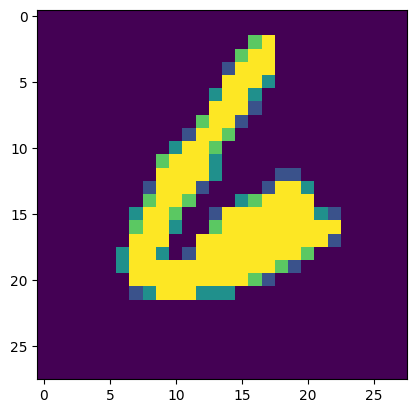

Ground Truth: 6 | Predicted: 6


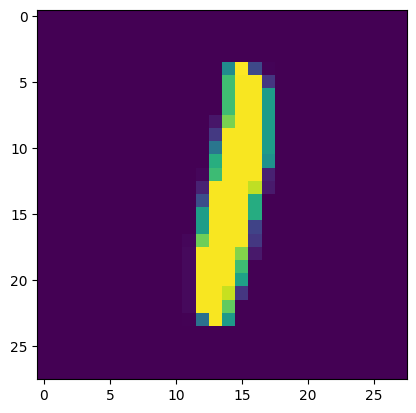

Ground Truth: 1 | Predicted: 1


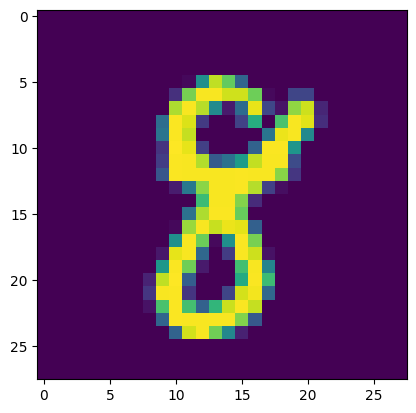

Ground Truth: 8 | Predicted: 8


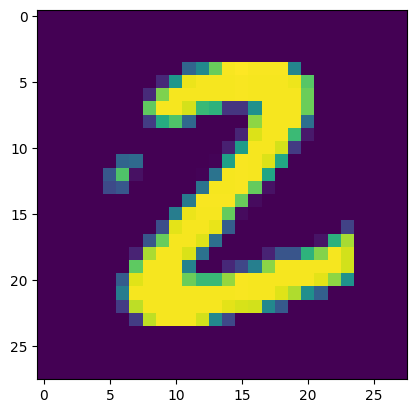

Ground Truth: 2 | Predicted: 2


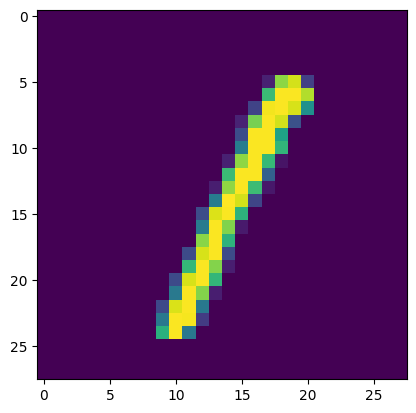

Ground Truth: 1 | Predicted: 1


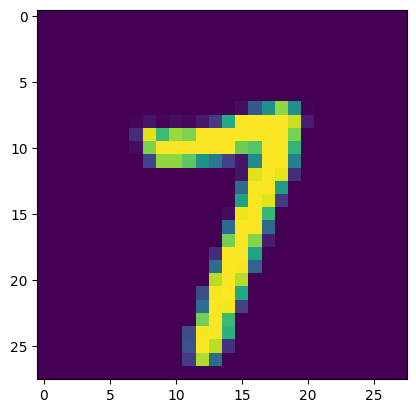

Ground Truth: 7 | Predicted: 7


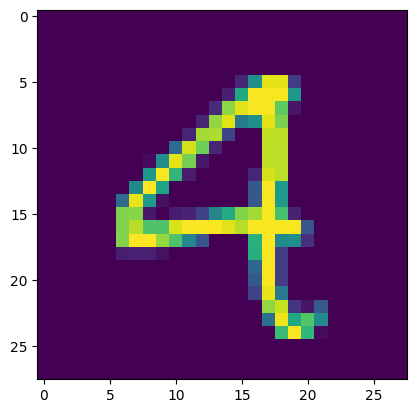

Ground Truth: 4 | Predicted: 4


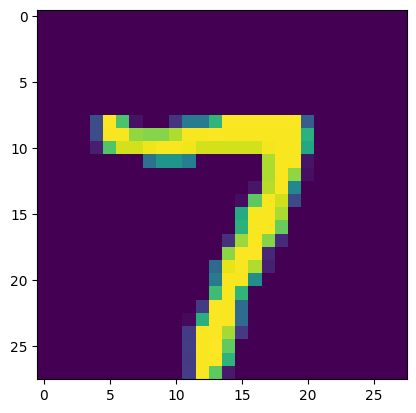

Ground Truth: 7 | Predicted: 7


In [294]:
# Random predictions:

for _ in range(8):
    index = np.random.randint(0, x_test.shape[0])

    sample = x_test[index]                  # (28, 28, 1)
    sample = tf.expand_dims(sample, axis=0) # (1, 28, 28, 1)
    
    ground_truth = get_label(y_test[index])

    predicted = model.predict(sample, verbose=0) # (1, 10)
    predicted = get_label(predicted)             # Label
    
    # Show image
    plt.imshow(tf.reshape(sample, (28, 28)))
    plt.show()
    print(f'Ground Truth: {ground_truth} | Predicted: {predicted}')

In [287]:
# Compute accuracy on validation:

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.08755015581846237
Test accuracy: 0.9824000000953674
